# 构建变分自编码器

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tYXN0ZXIvcHJvYmFiaWxpdHkvemhfY24vbWluZHNwb3JlX3VzaW5nX3RoZV92YWUuaXB5bmI=&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/probability/zh_cn/mindspore_using_the_vae.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/probability/zh_cn/mindspore_using_the_vae.py)
&emsp;[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/probability/docs/source_zh_cn/using_the_vae.ipynb)
本篇介绍如何使用MindSpore Probability中的`variational`模块和`dpn`模块实现变分自编码器。变分自编码器是经典的应用了变分推断的深度概率模型，用来学习潜在变量的表示，通过该模型，不仅可以压缩输入数据，还可以生成该类型的新图像。

本例整体流程如下：

1. 数据集准备
2. 定义条件变分自编码器网络；
3. 定义损失函数和优化器；
4. 训练生成模型。
5. 生成新样本或重构输入样本。

> 本例适用于GPU和Ascend环境。你可以在这里下载完整的样例代码：<https://gitee.com/mindspore/mindspore/tree/master/tests/st/probability/dpn>。

## 数据准备

### 下载数据集

以下示例代码将MNIST数据集下载并解压到指定位置。

In [ ]:
import os
import requests

def download_dataset(dataset_url, path):
    filename = dataset_url.split("/")[-1]
    if not os.path.exists(path):
        os.makedirs(path)
    res = requests.get(dataset_url, stream=True, verify=False)
    save_path = os.path.join(path, filename)
    with open(save_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)

train_path = "datasets/MNIST_Data/train"
test_path = "datasets/MNIST_Data/test"

download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte", test_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte", test_path)

下载的数据集文件的目录结构如下：

```text
./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

### 数据增强

将数据集增强为适应VAE网络训练要求的数据，本例主要是将原始图片像素大小由$28\times28$增强为$32\times32$，同时将多张图片组成1个`batch`来加速训练。

In [2]:
import mindspore.dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """
    create dataset for train or test
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width))  # Bilinear mode
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()

    # apply map operations on images
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    mnist_ds = mnist_ds.batch(batch_size)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

## 定义变分自编码器网络

变分自编码器的构成主要分为三个部分，编码器，解码器和隐空间。使用dpn模块来构造变分自编码器尤为简单，你只需要自定义编码器和解码器（DNN模型），调用VAE接口即可。

其中：

编码器（Encoder）主要作用是将训练数据进行降维，压缩，提取特征，形成特征向量，存储在隐空间中。

解码器（Decoder）主要作用是将训练数据隐空间分布的参数进行解码，还原生成出新的图像。

隐空间主要作用是将模型的特征按照某种分布特性进行存储，属于编码器和解码器中间的桥梁。

In [3]:
import os
import mindspore.nn as nn
from mindspore import context, Tensor
import mindspore.ops as ops
from mindspore.nn.probability.dpn import VAE

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
IMAGE_SHAPE = (-1, 1, 32, 32)
image_path = os.path.join("./datasets/MNIST_Data", "train")

class Encoder(nn.Cell):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Dense(1024, 800)
        self.fc2 = nn.Dense(800, 400)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x


class Decoder(nn.Cell):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Dense(400, 1024)
        self.sigmoid = nn.Sigmoid()
        self.reshape = ops.Reshape()

    def construct(self, z):
        z = self.fc1(z)
        z = self.reshape(z, IMAGE_SHAPE)
        z = self.sigmoid(z)
        return z

# define the encoder and decoder
encoder = Encoder()
decoder = Decoder()
# define the vae model
vae = VAE(encoder, decoder, hidden_size=400, latent_size=20)

## 定义优化器和损失函数

损失函数采用`ELBO`函数，`ELBO`是变分推断专用的损失函数，此函数用于计算解码图像和原图像的差值，并通过对比两个图像的差值，以及图像分布的均值之差来计算两图的损失情况。

优化器采用`nn.Adam`来最小化损失值。

In [4]:
from mindspore.nn.probability.infer import ELBO

# define the loss function
net_loss = ELBO(latent_prior='Normal', output_prior='Normal')
# define the optimizer
optimizer = nn.Adam(params=vae.trainable_params(), learning_rate=0.001)
net_with_loss = nn.WithLossCell(vae, net_loss)

参数解释：

- num_classes：类别数量，本例中为0-9个数字，共计10个种类。
- ConditionalVAE：条件自编码器模型，将编码器，解码器，压缩大小，隐空间维度和类别数量等变分自编码器网络初始化。
    - `encoder`：编码器网络。
    - `decoder`：解码器网络。
    - `hiddend_size`：数据压缩后的大小，本例为400。
    - `latent_size`：隐空间的向量维度，向量维度越大，分别的特征维度越多，图像特征越清晰，本例中可调节维度大小为20。
- ELBO：变分自编码器的损失函数。
    - `latent_prior`：隐空间初始化分布，本例中隐空间的参数遵循正态分布。
    - `output_prior`：输出权重的初始化分布，本例中其权重参数初始化分布遵循正态分布。
- nn.Adam：优化器。

## 训练生成模型

生成训练数据，将调用上述代码中`vi`的训练模式，对模型进行训练，训练完成后打印出模型的loss值。

In [5]:
from mindspore.nn.probability.infer import SVI

vi = SVI(net_with_loss=net_with_loss, optimizer=optimizer)
# define the training dataset
ds_train = create_dataset(image_path, 32, 1)
# run the vi to return the trained network.
vae = vi.run(train_dataset=ds_train, epochs=10)
# get the trained loss
trained_loss = vi.get_train_loss()
print(trained_loss)

45.09206426798502


参数解释：

- SVI：模型函数，类似MindSpore中的Model，此函数为变分自编码器专用模型函数。

## 构建图片可视化函数

可将一个batch为32的图片数据可视化，方便对比原图与经过变分自编码器生成图片之间的差异。

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(sample_data, col_num=4, row_num=8, count=0):
    for i in sample_data:
        plt.subplot(col_num, row_num, count+1)
        plt.imshow(np.squeeze(i.asnumpy()))
        plt.axis("off")
        count += 1
    plt.show()

## 随机生成图片

使用VAE随机采样生成图片。


=============The Random generated Images=============


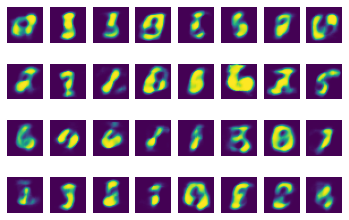

In [8]:
generated_sample = vae.generate_sample(32, IMAGE_SHAPE)

print("\n=============The Random generated Images=============")
plot_image(generated_sample)

### 样本重建

使用训练好的模型，查看重建数据的能力如何，这里取一组原始数据进行重建，执行如下代码：

The shape of the reconstructed sample is  (32, 1, 32, 32)

=============The Original Images=============


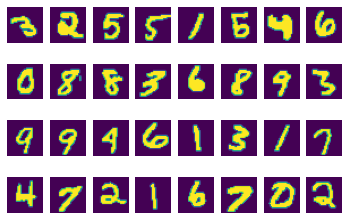


============The Reconstruct Images=============


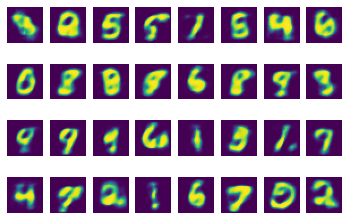

In [9]:
sample = next(ds_train.create_dict_iterator(output_numpy=True, num_epochs=1))
sample_x = Tensor(sample['image'], dtype=mstype.float32)

reconstructed_sample = vae.reconstruct_sample(sample_x)
print('The shape of the reconstructed sample is ', reconstructed_sample.shape)
print("\n=============The Original Images=============")
plot_image(sample_x)
print("\n============The Reconstruct Images=============")
plot_image(reconstructed_sample)

对比原图片，VAE生成的图片可以一一对应上原始图片，但还稍显模糊。说明训练效果已经达到但还有提升空间。